In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs,make_moons,make_circles

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue","black","grey"])

In [0]:
np.random.seed(0)

In [35]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=4, random_state=0)
print(data.shape, labels.shape)

(1000, 4) (1000,)


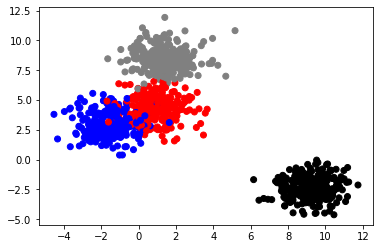

In [36]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape,Y_train.shape,Y_val.shape)

(750, 4) (250, 4) (750,) (250,)


In [38]:

enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0, 0, 0), 1 -> (0, 1, 0, 0, 0, 0), 2 -> (0, 0, 1, 0, 0, 0), 3 -> (0, 0, 0, 1, 0, 0),4 -> (0, 0, 0, 0, 1, 0),5 -> (0, 0, 0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)



(750, 4) (250, 4)


In [39]:
y_OH_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [0]:
class DeepNeuralNetwork:
  def __init__(self,init_method='random',activation_function='sigmoid',leaky_slope=0.1):
    self.params={}
    self.params_h=[]
    self.num_layers=3
    self.layer_sizes=[4,2,2,4]
    self.activation_function=activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
  
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    elif init_method == "zeros":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
        self.params["B"+str(i)]=np.zeros((1,self.layer_sizes[i]))
    
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0

  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)

  def grad_activation(self, X):
     if self.activation_function == "sigmoid":
       return X*(1-X) 
     elif self.activation_function == "tanh":
       return (1-np.square(X))
     elif self.activation_function == "relu":
         return 1.0*(X>0)
     elif self.activation_function == "leaky_relu":
       d=np.zeros_like(X)
       d[X<=0]=self.leaky_slope
       d[X>0]=1
       d[np.all(np.isfinite(d)) == True] = 0
       return d


  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)

  def forward_pass(self, X, params = None):
     if params is None:
         params = self.params
     self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 4) * (4, 2) -> (N, 2)
     self.H1 = self.forward_activation(self.A1) # (N, 2)
     self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
     self.H2 = self.softmax(self.A2) # (N, 2)
     self.A3 = np.matmul(self.H2, params["W3"]) + params["B3"] # (N, 2) * (2, 4) -> (N, 4)
     self.H3 = self.softmax(self.A3) # (N, 4)
     return self.H3
   
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
    
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA3"] = self.H3 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW3"]=  np.matmul(self.H2.T, self.gradients["dA3"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB3"] = np.sum(self.gradients["dA3"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH2"] = np.matmul(self.gradients["dA3"], params["W3"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA2"] = np.multiply(self.gradients["dH2"], self.grad_activation(self.H2))# (N,2) .* (N,2) ->(N,2)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 2) -> (1,2)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 2) * (2, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (4, N) * (N, 2) -> (4, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)

  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=4, eps=1e-8,  
          beta=0.4, beta1=0.5, beta2=0.3, gamma=0.5 ):
    
      if display_loss:
        loss = {}
        Y_pred = self.predict(X)
        loss[0] = log_loss(np.argmax(Y, axis=1), Y_pred)
        self.w_1 = []
        self.b_1 = []
        self.w_2 = []
        self.b_2 = []
        self.w_3 = []
        self.b_3 = []
        self.e_h = []

      for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        m = X.shape[0]
      
        if algo == "GD":
           self.grad(X, Y)
           for i in range(1,self.num_layers+1):
              self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
              self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
           self.append_log()
          
        elif algo == "MiniBatch":
          for k in range(0,m,mini_batch_size):
            self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
            for i in range(1,self.num_layers+1):
              self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
              self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
          self.append_log()
            
        elif algo == "Momentum":
          self.grad(X, Y)
          for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
            self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
            self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
            self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          self.append_log()
          
        elif algo == "NAG":
          temp_params = {}
          for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
            self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
            temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
            temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
          self.grad(X,Y,temp_params)
          for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
            self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
            self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
            self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
          self.append_log()
          self.prev_update_params=self.update_params 
        
        elif algo == "AdaGrad":
          self.grad(X, Y)
          for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
            self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
            self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
            self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
          self.append_log()
      
        elif algo == "RMSProp":
          self.grad(X, Y)
          for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
            self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
            self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
            self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
          self.append_log()
      
        elif algo == "Adam":
          self.grad(X, Y)
          num_updates=0
          for i in range(1,self.num_layers+1):
            num_updates+=1
            self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
            self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
            m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
            v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
            self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
            self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
            self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
            m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
            v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
            self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
          self.append_log()
          
          
        if display_loss:
           Y_pred = self.predict(X)
           loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)
           self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(),self.params['W3'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel(),self.params['B3'].ravel())))
    
      if display_loss:
         fig= plt.figure(figsize=(5,5))
         plt.plot(list(loss.values()), '-o', markersize=5)
         plt.xlabel('Epochs')
         plt.ylabel('Log Loss')
         plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
  
  def predict_h1(self, X):
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(self.h1)
    return np.array(Y_pred)
  
  def predict_h2(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(self.h2)
    return np.array(Y_pred)
  
  def predict_h3(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(self.h3)
    return np.array(Y_pred)
  
  def append_log(self):
    self.w_1.append(self.params["W1"].ravel())
    self.b_1.append(self.params["B1"].ravel())
    self.w_2.append(self.params["W2"].ravel())
    self.b_2.append(self.params["B2"].ravel())
    self.w_3.append(self.params["W3"].ravel())
    self.b_3.append(self.params["B3"].ravel())
         
    
        
      



  
    
    

In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
    plt.show()

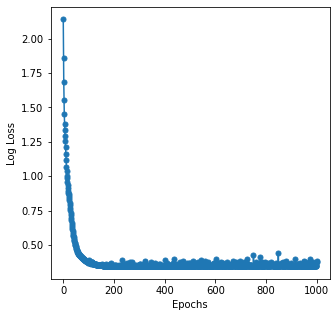

Training accuracy 0.7547
Validation accuracy 0.748


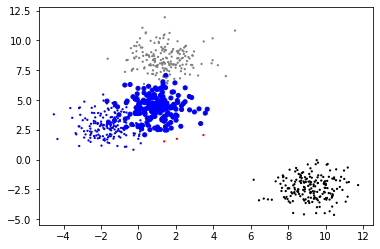

In [224]:
model = DeepNeuralNetwork(init_method='xavier',activation_function='tanh')
model.fit(X_train, y_OH_train, epochs=1000, eta=0.1, algo="RMSProp", display_loss=True,beta1=0.2)
print_accuracy()

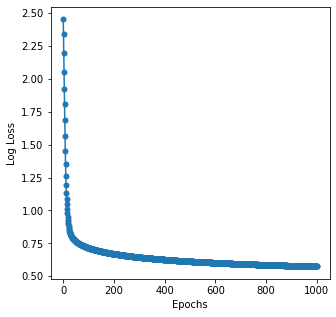

Training accuracy 0.7053
Validation accuracy 0.704


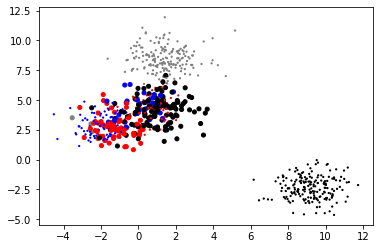

In [225]:

model = DeepNeuralNetwork(init_method='he',activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=1000, eta=0.1, algo="Adam", display_loss=True)
print_accuracy()

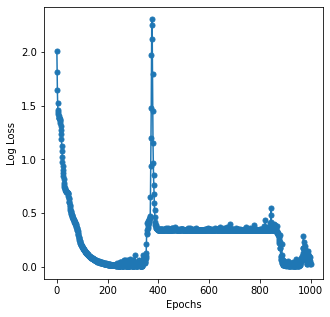

Training accuracy 0.996
Validation accuracy 0.984


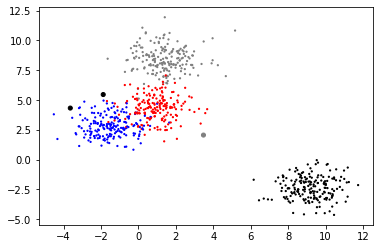

In [226]:
model = DeepNeuralNetwork(init_method='random',activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=1000, eta=0.1, algo="Adam", display_loss=True)
print_accuracy()

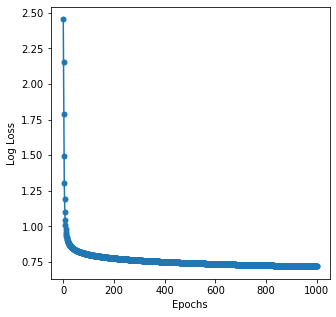

Training accuracy 0.648
Validation accuracy 0.656


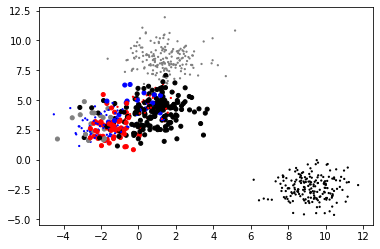

In [227]:
model = DeepNeuralNetwork(init_method='he',activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=1000, eta=1, algo="Momentum", display_loss=True)
print_accuracy()

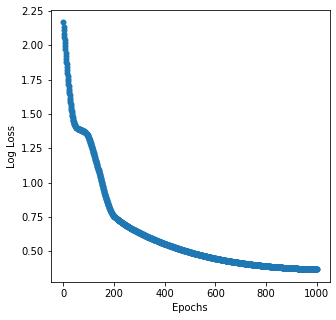

Training accuracy 0.7507
Validation accuracy 0.744


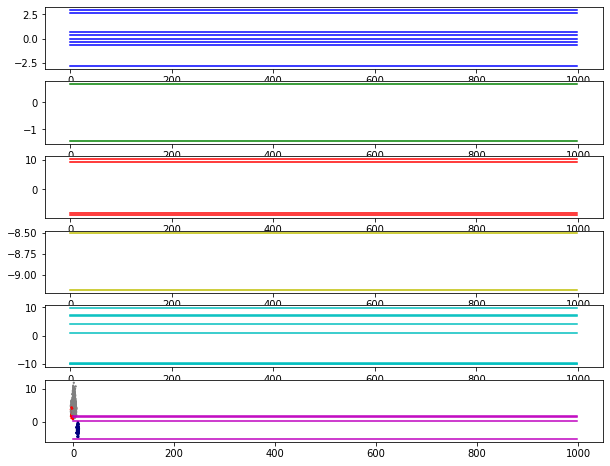

In [229]:
model = DeepNeuralNetwork(init_method='he',activation_function='tanh')
model.fit(X_train, y_OH_train, epochs=1000, eta=0.01, algo="RMSProp", display_loss=True)
from pylab import *
fig= plt.figure(figsize=(10,8))
subplot(6, 1,1)
plt.plot(model.w_1, 'b')
subplot(6, 1,2)
plt.plot(model.b_1, 'g')
subplot(6, 1,3)
plt.plot(model.w_2, 'r')
subplot(6, 1,4)
plt.plot(model.b_2, 'y')
subplot(6, 1,5)
plt.plot(model.w_3, 'c')
subplot(6, 1,6)
plt.plot(model.b_3, 'm')
print_accuracy()

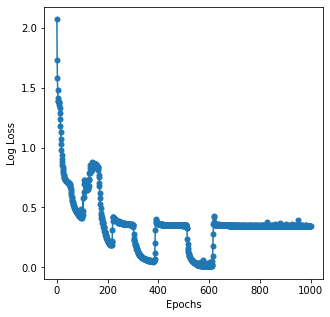

Training accuracy 0.748
Validation accuracy 0.752


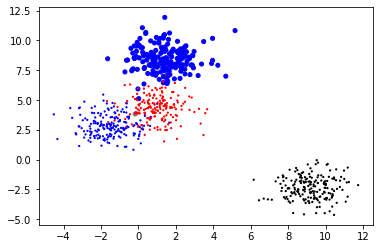

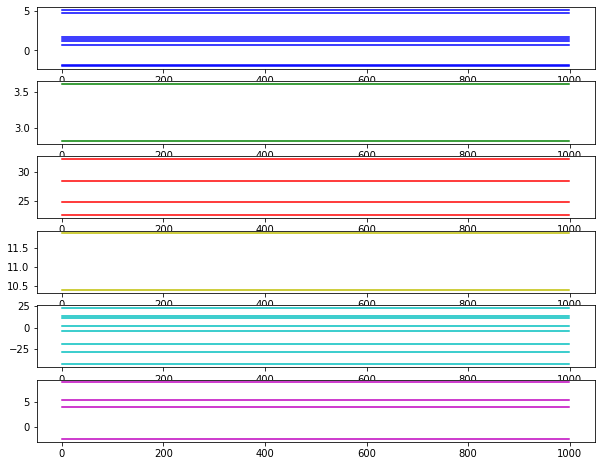

In [157]:
model = DeepNeuralNetwork(init_method='xavier',activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=1000, eta=0.1, algo="RMSProp", display_loss=True)
from pylab import *
print_accuracy()
fig= plt.figure(figsize=(10,8))

subplot(6, 1,1)
plt.plot(model.w_1, 'b')
subplot(6, 1,2)
plt.plot(model.b_1, 'g')
subplot(6, 1,3)
plt.plot(model.w_2, 'r')
subplot(6, 1,4)
plt.plot(model.b_2, 'y')
subplot(6, 1,5)
plt.plot(model.w_3, 'c')
subplot(6, 1,6)
plt.plot(model.b_3, 'm')


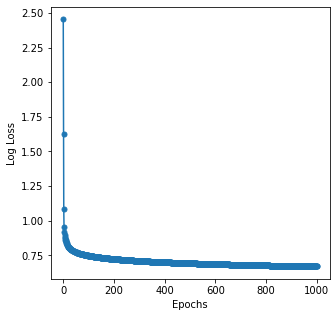

Training accuracy 0.66
Validation accuracy 0.672


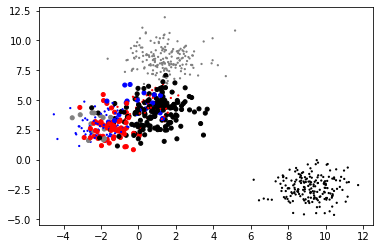

Training accuracy 0.66
Validation accuracy 0.672


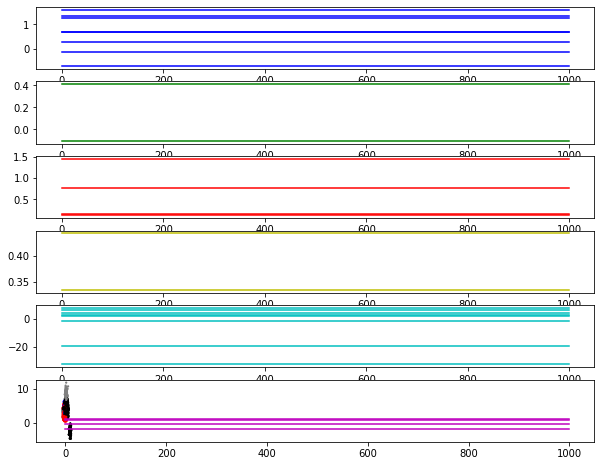

In [235]:
model = DeepNeuralNetwork(init_method='he',activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=1000, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()
from pylab import *
fig= plt.figure(figsize=(10,8))
subplot(6, 1,1)
plt.plot(model.w_1, 'b')
subplot(6, 1,2)
plt.plot(model.b_1, 'g')
subplot(6, 1,3)
plt.plot(model.w_2, 'r')
subplot(6, 1,4)
plt.plot(model.b_2, 'y')
subplot(6, 1,5)
plt.plot(model.w_3, 'c')
subplot(6, 1,6)
plt.plot(model.b_3, 'm')
print_accuracy()

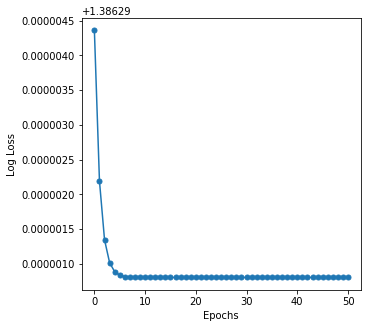

Training accuracy 0.2507
Validation accuracy 0.248


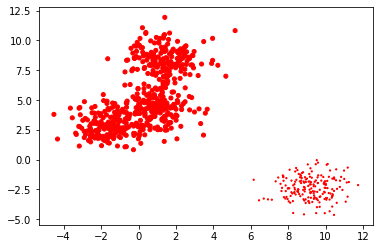

zeros sigmoid
Weight and biases of zeros sigmoid below

--

--



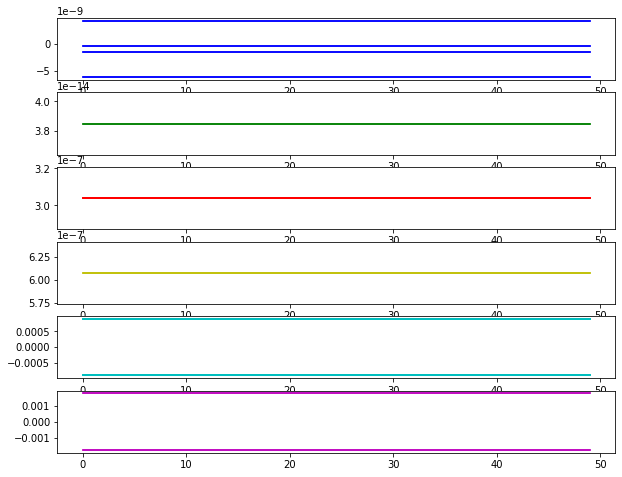

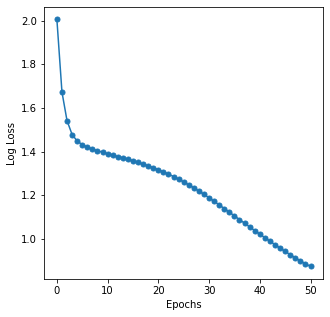

Training accuracy 0.8267
Validation accuracy 0.792


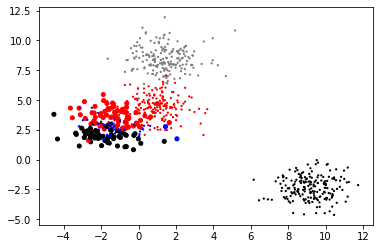

random sigmoid
Weight and biases of random sigmoid below

--

--



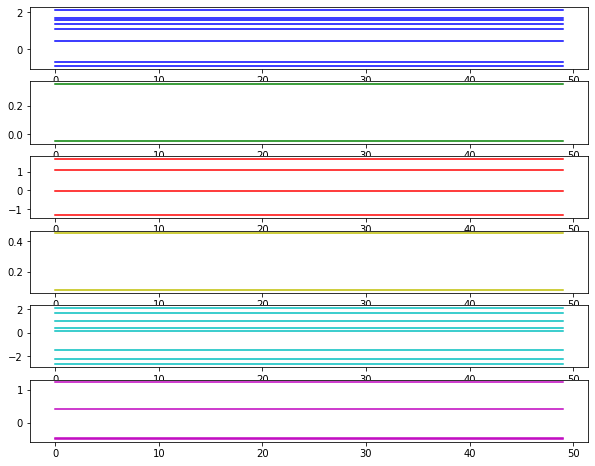

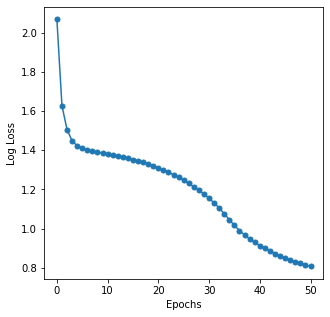

Training accuracy 0.708
Validation accuracy 0.716


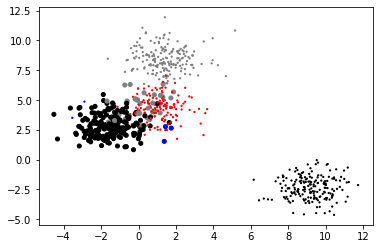

xavier sigmoid
Weight and biases of xavier sigmoid below

--

--



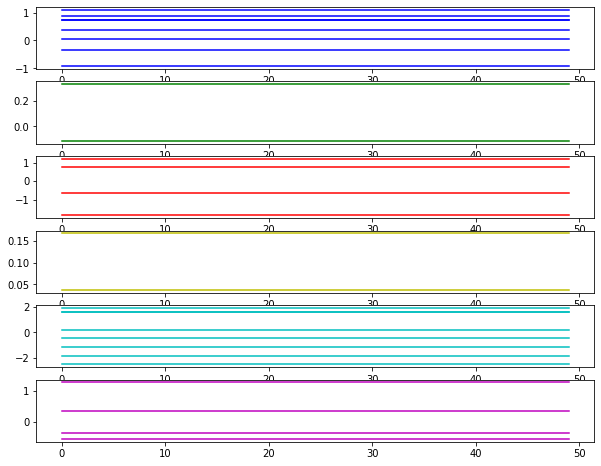

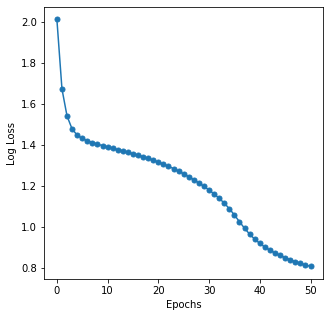

Training accuracy 0.5547
Validation accuracy 0.556


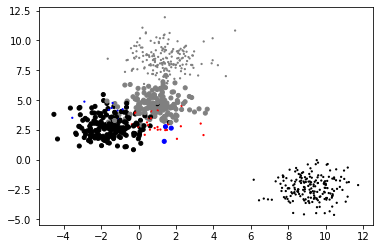

he sigmoid
Weight and biases of he sigmoid below

--

--



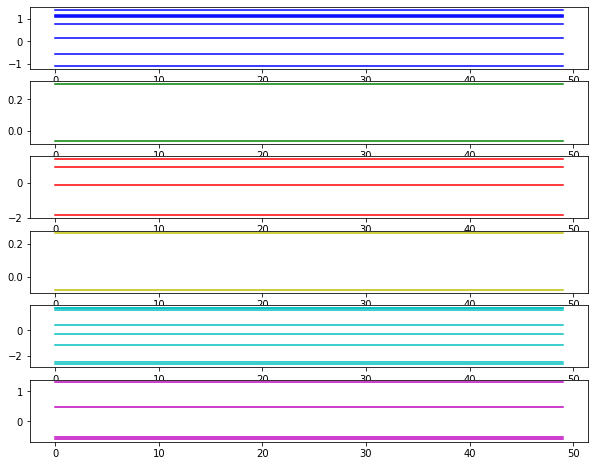

In [167]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['sigmoid']:
    
    model = DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=50, eta=1, algo="GD", display_loss=True)
    
    print_accuracy()
    print(init_method, activation_function)
    print("Weight and biases of "+init_method+ " "+activation_function + " below")
    print('\n--')
    fig= plt.figure(figsize=(10,8))
    subplot(6, 1,1)
    plt.plot(model.w_1, 'b')
    subplot(6, 1,2)
    plt.plot(model.b_1, 'g')
    subplot(6, 1,3)
    plt.plot(model.w_2, 'r')
    subplot(6, 1,4)
    plt.plot(model.b_2, 'y')
    subplot(6, 1,5)
    plt.plot(model.w_3, 'c')
    subplot(6, 1,6)
    plt.plot(model.b_3, 'm')
    print('\n--\n')

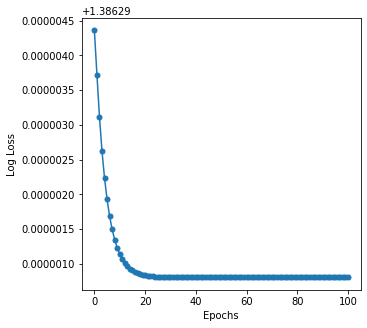

Training accuracy 0.2507
Validation accuracy 0.248


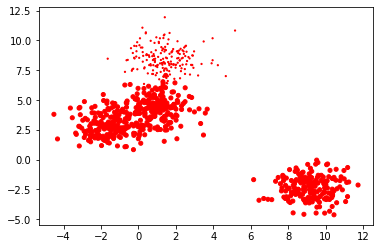

zeros tanh
Weight and biases of zeros tanh below

--

--



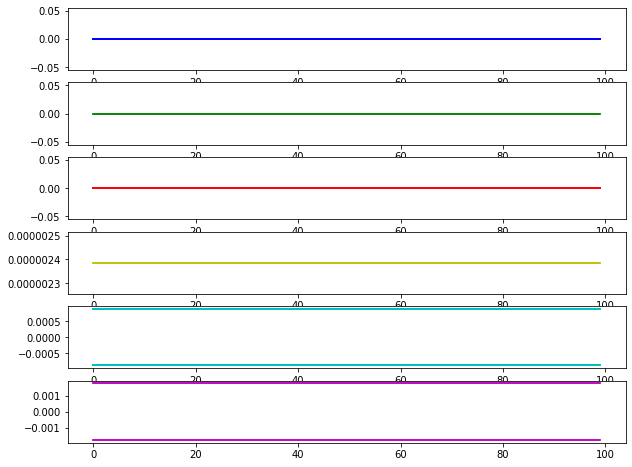

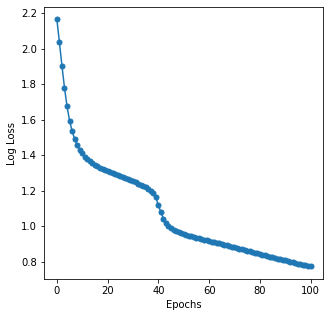

Training accuracy 0.7493
Validation accuracy 0.736


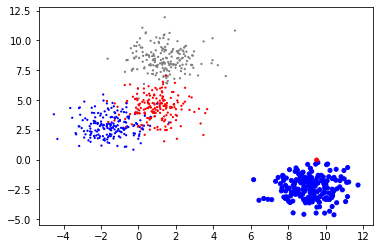

random tanh
Weight and biases of random tanh below

--

--



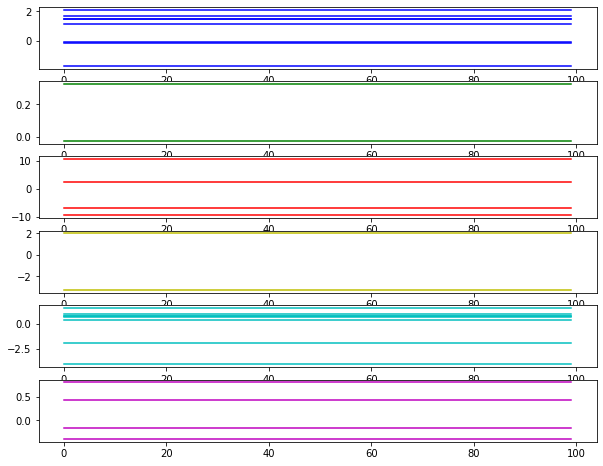

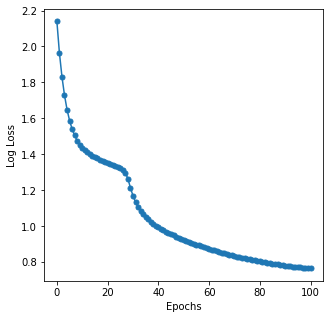

Training accuracy 0.752
Validation accuracy 0.748


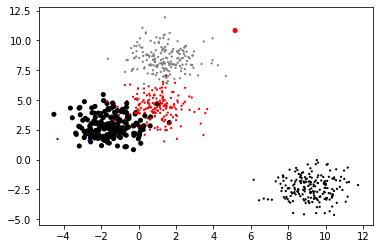

xavier tanh
Weight and biases of xavier tanh below

--

--



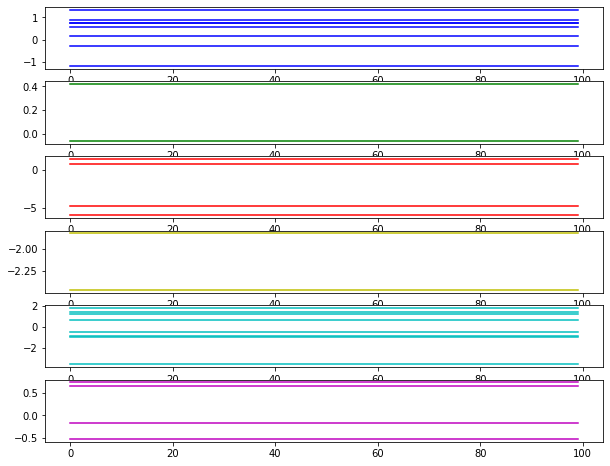

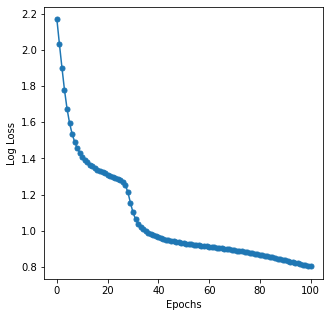

Training accuracy 0.7507
Validation accuracy 0.748


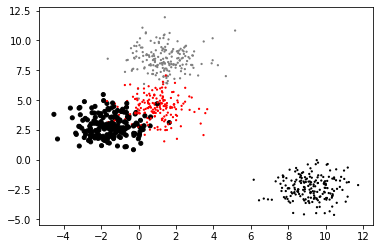

he tanh
Weight and biases of he tanh below

--

--



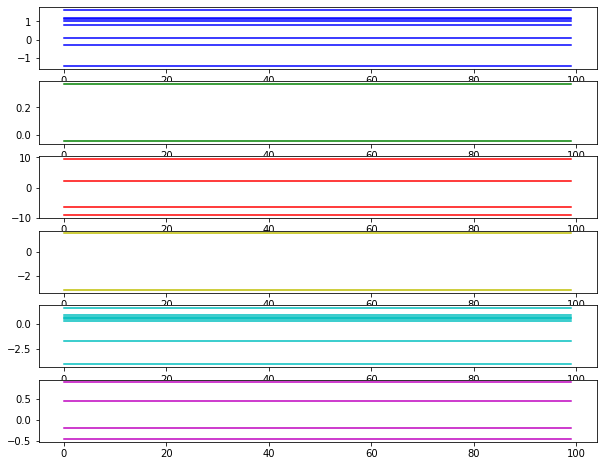

In [176]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['tanh']:
    
    model = DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=100, eta=0.5, algo="NAG", display_loss=True)
    print_accuracy()
    print(init_method, activation_function)
    print("Weight and biases of "+init_method+ " "+activation_function + " below")
    print('\n--')

    fig= plt.figure(figsize=(10,8))
    subplot(6, 1,1)
    plt.plot(model.w_1, 'b')
    subplot(6, 1,2)
    plt.plot(model.b_1, 'g')
    subplot(6, 1,3)
    plt.plot(model.w_2, 'r')
    subplot(6, 1,4)
    plt.plot(model.b_2, 'y')
    subplot(6, 1,5)
    plt.plot(model.w_3, 'c')
    subplot(6, 1,6)
    plt.plot(model.b_3, 'm')
    print('\n--\n')
    
    

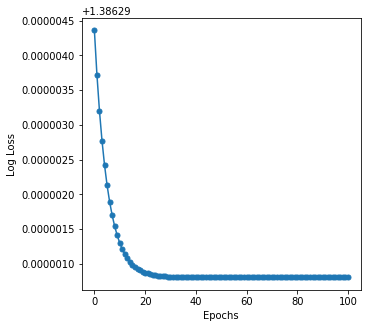

Training accuracy 0.2507
Validation accuracy 0.248


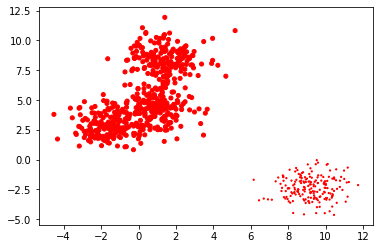

zeros leaky_relu
Weight and biases of zeros leaky_relu below

--

--



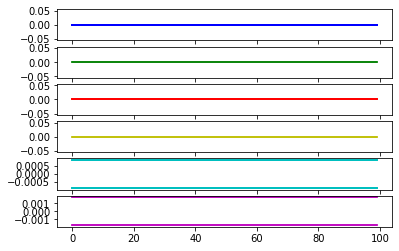

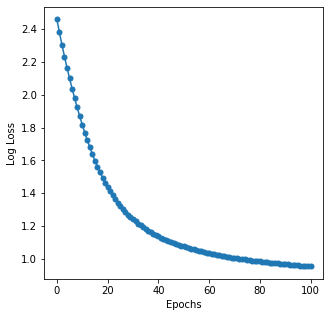

Training accuracy 0.516
Validation accuracy 0.516


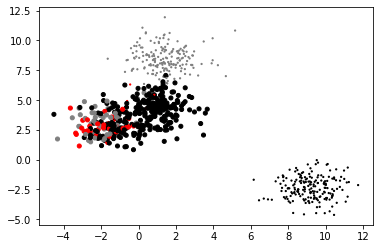

random leaky_relu
Weight and biases of random leaky_relu below

--

--



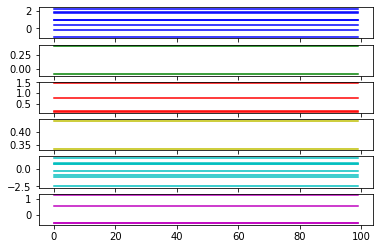

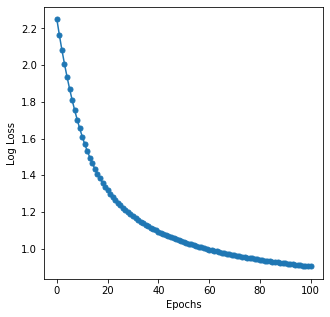

Training accuracy 0.5987
Validation accuracy 0.572


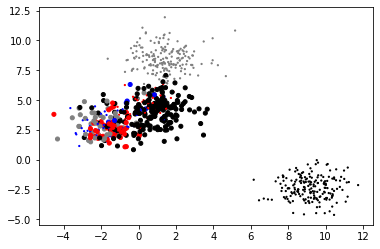

xavier leaky_relu
Weight and biases of xavier leaky_relu below

--

--



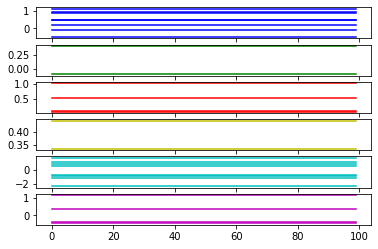

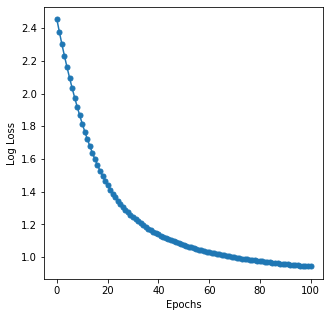

Training accuracy 0.5307
Validation accuracy 0.528


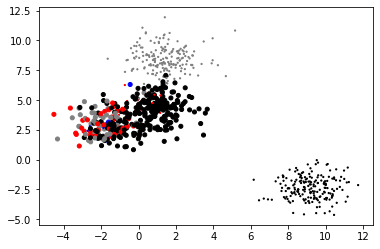

he leaky_relu
Weight and biases of he leaky_relu below

--

--



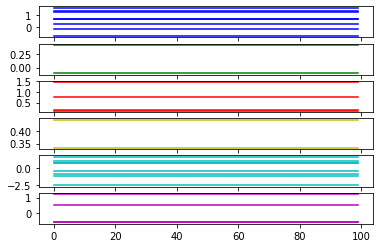

In [175]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['leaky_relu']:
     model = DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
     model.fit(X_train, y_OH_train, epochs=100, eta=0.25, algo="GD", display_loss=True)
     print_accuracy()
     print(init_method, activation_function)
     print("Weight and biases of "+init_method+ " "+activation_function + " below")
     print('\n--')
     subplot(6, 1,1)
     plt.plot(model.w_1, 'b')
     subplot(6, 1,2)
     plt.plot(model.b_1, 'g')
     subplot(6, 1,3)
     plt.plot(model.w_2, 'r')
     subplot(6, 1,4)
     plt.plot(model.b_2, 'y')
     subplot(6, 1,5)
     plt.plot(model.w_3, 'c')
     subplot(6, 1,6)
     plt.plot(model.b_3, 'm')
     print('\n--\n')
     

In [0]:
def post_process(scatter_plot=True, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
      
    if gradient_plot:
      h = np.asarray(model.params_h)
      h_diff = (h[0:-1, :] - h[1:, :])
      for i in range(28):
        plt.subplot(10, 3, i+1)
        plt.plot(h_diff[:, i], '-')
        plt.ylim((-plot_scale, plot_scale))
        plt.yticks([])
        plt.xticks([])
      plt.show()

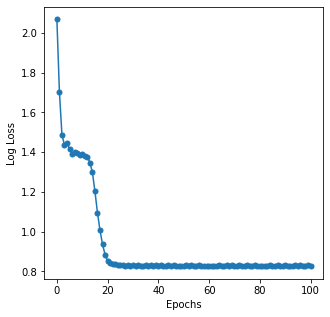

Training accuracy 0.5
Validation accuracy 0.5


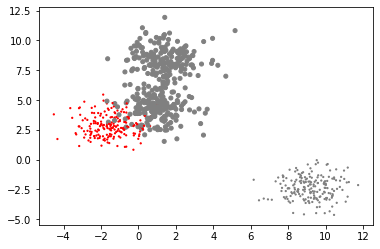

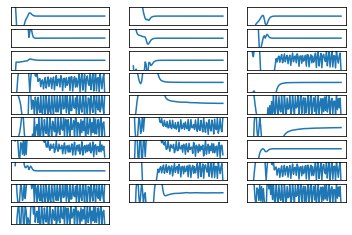

In [212]:
model = DeepNeuralNetwork(init_method='xavier', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.21, algo="Adam", display_loss=True)
post_process()

zeros sigmoid


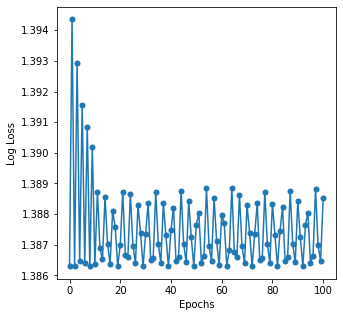

Training accuracy 0.2493
Validation accuracy 0.252


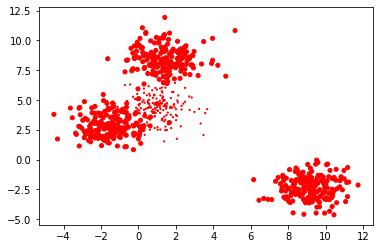

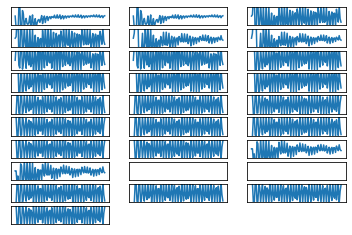


--

random sigmoid


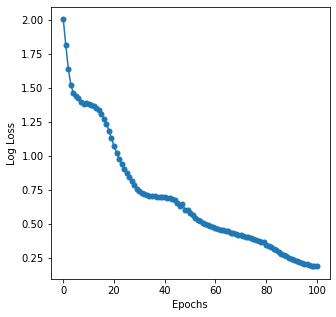

Training accuracy 0.9987
Validation accuracy 0.984


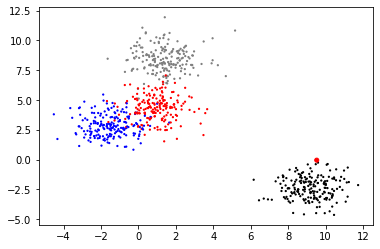

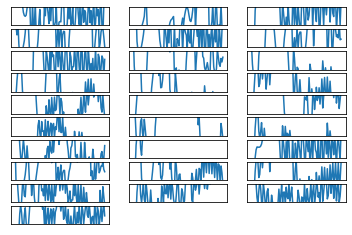


--

xavier sigmoid


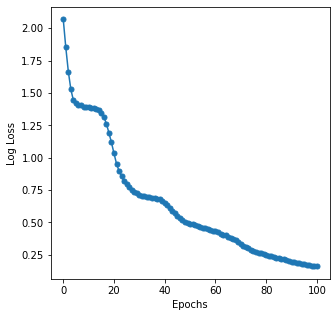

Training accuracy 0.9987
Validation accuracy 0.988


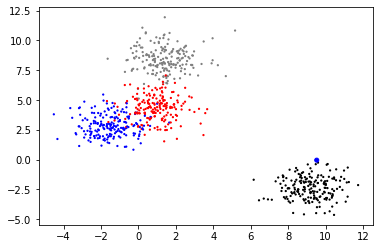

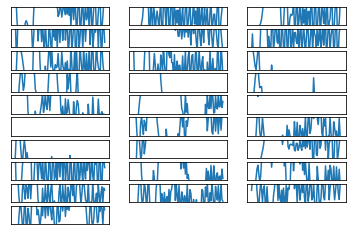


--

he sigmoid


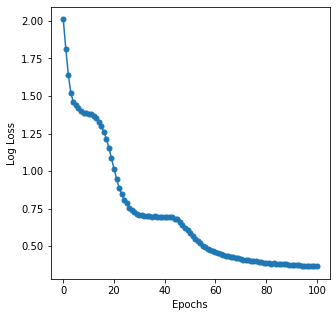

Training accuracy 0.7493
Validation accuracy 0.74


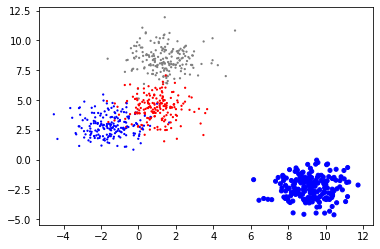

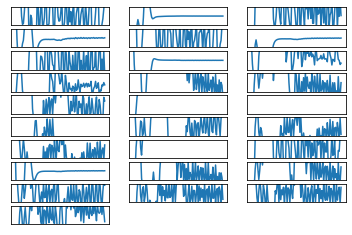


--



In [213]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['sigmoid']:
    print(init_method, activation_function)
    model =  DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=100, eta=0.1, algo="Adam", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

zeros tanh


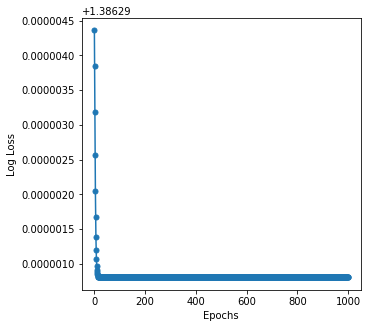

Training accuracy 0.2507
Validation accuracy 0.248


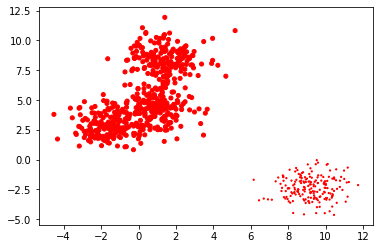

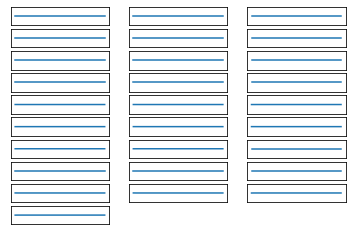


--

random tanh


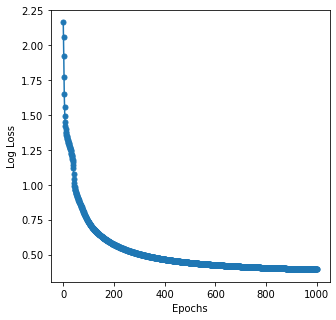

Training accuracy 0.7507
Validation accuracy 0.744


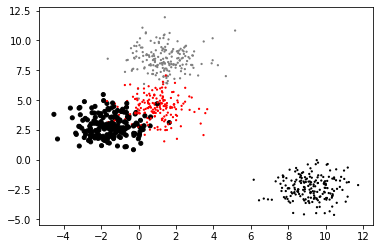

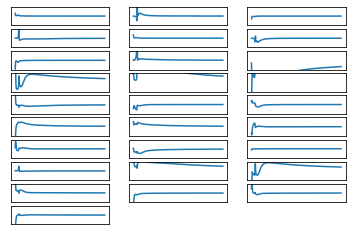


--

xavier tanh


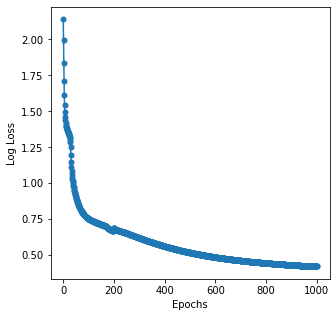

Training accuracy 0.764
Validation accuracy 0.764


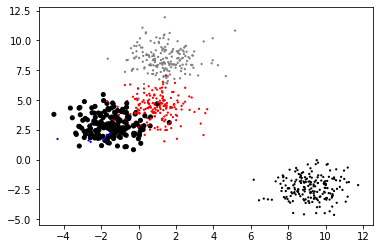

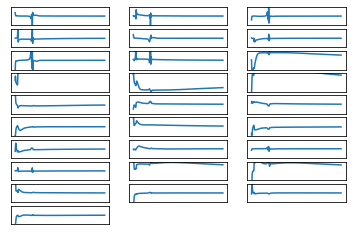


--

he tanh


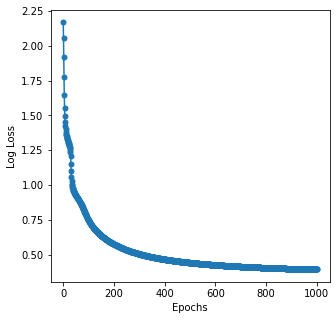

Training accuracy 0.7507
Validation accuracy 0.744


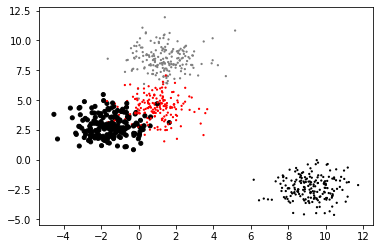

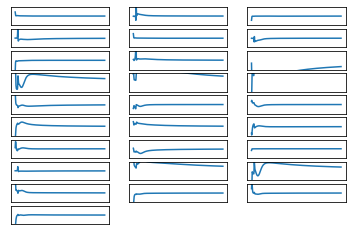


--



In [205]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['tanh']:
    print(init_method, activation_function)
    model = DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=1000, eta=0.2, algo="Momentum", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

zeros leaky_relu


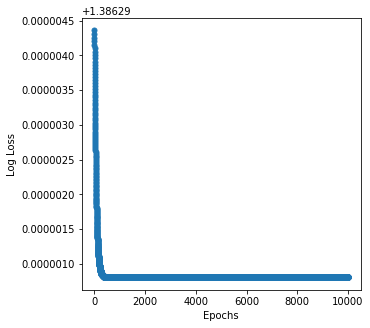

Training accuracy 0.2507
Validation accuracy 0.248


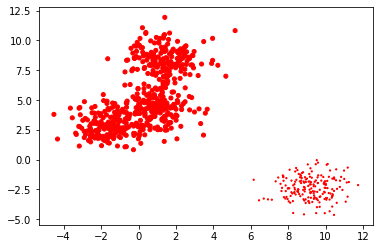

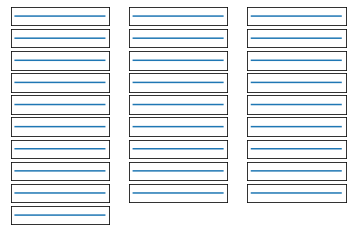


--

random leaky_relu


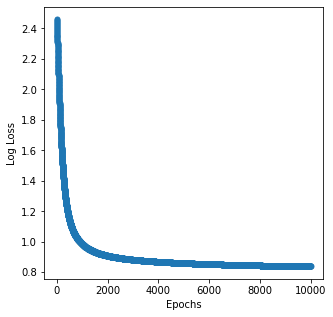

Training accuracy 0.58
Validation accuracy 0.56


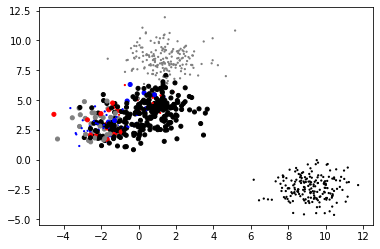

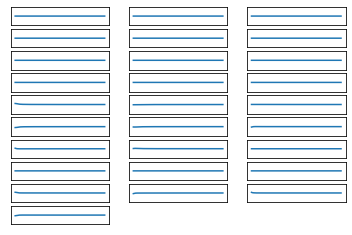


--

xavier leaky_relu


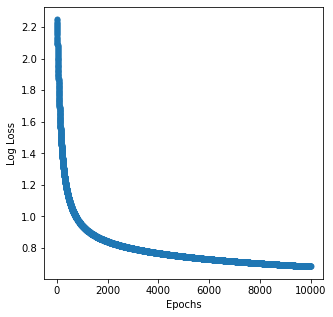

Training accuracy 0.704
Validation accuracy 0.708


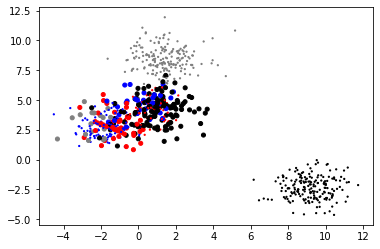

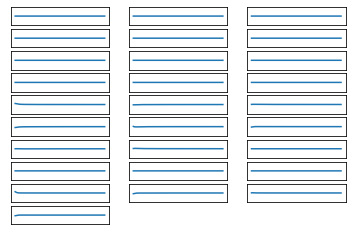


--

he leaky_relu


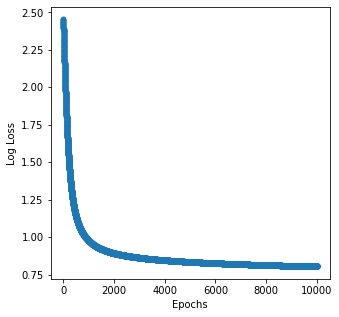

Training accuracy 0.6053
Validation accuracy 0.584


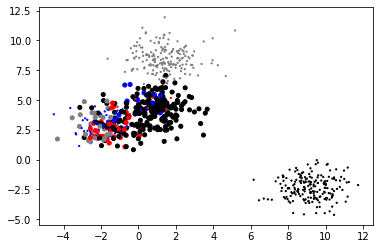

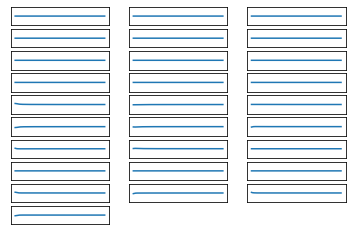


--



In [209]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['leaky_relu']:
    print(init_method, activation_function)
    model = DeepNeuralNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=10000, eta=0.02, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')